In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

import shap
import lime
import json

from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [2]:
data_c_n = pd.read_csv('data/onlycountry.csv')

data = pd.read_csv('data/nocountry.csv')
data['snapshot_date'] = pd.to_datetime(data['snapshot_date'])
data['album_release_date'] = pd.to_datetime(data['album_release_date'])

data['release_to_chart_days'] = (data['snapshot_date'] - data['album_release_date']).dt.days

data['month'] = data['snapshot_date'].dt.month

def month_to_spring(month):
    if month in [3, 4, 5]:
        return 1
    else:
        return 0
    
def month_to_summer(month):
    if month in [6, 7, 8]:
        return 1
    else:
        return 0
    
def month_to_autumn(month):
    if month in [9, 10, 11]:
        return 1
    else:
        return 0

def month_to_winter(month):
    if month in [12, 1, 2]:
        return 1
    else:
        return 0
    


data['spring'] = data['month'].apply(month_to_spring)
data['summer'] = data['month'].apply(month_to_summer)
data['winter'] = data['month'].apply(month_to_winter)
data['autumn'] = data['month'].apply(month_to_autumn)

data['loudness_tempo_interaction'] = data['loudness'] * data['tempo']

print(data.head())

               spotify_id                          name  \
0  5vNRhkKd0yEAg8suGBpjeY                          APT.   
1  2plbrEY59IikOBgBGLjaoe              Die With A Smile   
2  2CGNAOSuO1MEFCbBRgUzjd             luther (with sza)   
3  0nj9Bq5sHDiTxSHunhgkFb                   squabble up   
4  0aB0v4027ukVziUGwVGYpG  tv off (feat. lefty gunplay)   

                         artists  daily_rank  daily_movement  weekly_movement  \
0               ROSÉ, Bruno Mars           1               0                1   
1          Lady Gaga, Bruno Mars           2               0               -1   
2            Kendrick Lamar, SZA           3               0               47   
3                 Kendrick Lamar           4               0               46   
4  Kendrick Lamar, Lefty Gunplay           5               1               45   

   country snapshot_date  popularity  is_explicit  ...  valence    tempo  \
0      NaN    2024-11-27          98        False  ...    0.939  149.027   
1     

In [3]:
normalized_data = data.copy()

columns_to_drop = ['spotify_id', 'daily_rank', 'daily_movement', 'weekly_movement', 'instrumentalness',  'month', 'name', 'country', 'artists', 'album_name', 'album_release_date', 'snapshot_date', 'key', 'mode', 'time_signature', 'spring', 'summer', 'winter', 'autumn', 'is_explicit']
for onecolumn in columns_to_drop:
    normalized_data.drop(columns=onecolumn, inplace=True)
    
normalized_data.fillna(normalized_data.mean(), inplace=True)
normalized_data.head()

,popularity,duration_ms,danceability,energy,loudness,speechiness,acousticness,liveness,valence,tempo,release_to_chart_days,loudness_tempo_interaction
0,98,169917,0.777,0.783,-4.477,0.2600,0.0283,0.3550,0.939,149.027,40.0,-667.193879
1,100,251667,0.521,0.592,-7.777,0.0304,0.3080,0.1220,0.535,157.969,103.0,-1228.524913
2,64,177598,0.707,0.575,-7.546,0.1250,0.2510,0.2480,0.576,138.008,6.0,-1041.408368
3,86,157992,0.874,0.672,-5.568,0.1980,0.0206,0.0783,0.711,103.921,5.0,-578.632128
4,85,220690,0.855,0.529,-6.679,0.2630,0.0837,0.4230,0.548,100.036,5.0,-668.140444


In [4]:
features = [col for col in normalized_data.columns if col != 'popularity']
n_data = {}

for column in features:
    min_val = normalized_data[column].min()
    max_val = normalized_data[column].max()
    if min_val != max_val:  # Avoid division by zero for constant columns
        n_data[column] = ((data[column] - min_val) / (max_val - min_val)).tolist()
    else:
        n_data[column] = [0.5] * len(data)

normalized_df = pd.DataFrame(n_data)
normalized_df.head()

,duration_ms,danceability,energy,loudness,speechiness,acousticness,liveness,valence,tempo,release_to_chart_days,loudness_tempo_interaction
0,0.309138,0.753121,0.791738,0.837316,0.262688,0.029030,0.358393,0.955532,0.634914,0.001302,0.790011
1,0.505914,0.398058,0.573178,0.630354,0.006581,0.317730,0.106719,0.527792,0.694269,0.003406,0.550284
2,0.327626,0.656033,0.553725,0.644842,0.112103,0.258896,0.242817,0.571202,0.561771,0.000167,0.630196
3,0.280434,0.887656,0.664721,0.768893,0.193530,0.021082,0.059516,0.714134,0.335508,0.000134,0.827832
4,0.431351,0.861304,0.501087,0.699216,0.266035,0.086213,0.431843,0.541556,0.309720,0.000134,0.789606


In [5]:
normalized_df['popularity'] = normalized_data['popularity']

In [6]:
# data_c = pd.read_csv('data/Filtered_Spotify_Data.csv')
# print(data_c['popularity'][0])
# data_c['snapshot_date'] = pd.to_datetime(data_c['snapshot_date'])
# data_c['album_release_date'] = pd.to_datetime(data_c['album_release_date'])
# data_c['release_to_chart_days'] = (data_c['snapshot_date'] - data_c['album_release_date']).dt.days
# data_c['loudness_tempo_interaction'] = data_c['loudness'] * data_c['tempo']
# data_c.dropna(subset=['country'], inplace=True)
# columns_to_drop = ['spotify_id', 'daily_rank', 'daily_movement', 'weekly_movement', 'instrumentalness', 'name', 'country', 'artists', 'album_name', 'album_release_date', 'snapshot_date', 'key', 'mode', 'time_signature', 'is_explicit']
# for onecolumn in columns_to_drop:
#     data_c.drop(columns=onecolumn, inplace=True) 
# data_c.fillna(data_c.mean(), inplace=True)

# features = [col for col in data_c.columns]
# n_data = {}

# for column in features:
#     if column != 'popularity':
#         min_val = data_c[column].min()
#         max_val = data_c[column].max()
#         if min_val != max_val:  # Avoid division by zero for constant columns
#             n_data[column] = ((data[column] - min_val) / (max_val - min_val)).tolist()
#         else:
#             n_data[column] = [0.5] * len(data)
#     else:
#         n_data[column] = data[column].tolist()

# data_c_n = pd.DataFrame(n_data)
# data_c_n.head()
# data_c_n.to_csv('data/onlycountry.csv')
print(data_c_n.columns)
data_n = data_c_n.copy()
data_c = normalized_df.copy()
data_n.fillna(data_n.mean(), inplace=True)
data_n.head()

Index(['Unnamed: 0', 'popularity', 'duration_ms', 'danceability', 'energy',
       'loudness', 'speechiness', 'acousticness', 'liveness', 'valence',
       'tempo', 'release_to_chart_days', 'loudness_tempo_interaction'],
      dtype='object')


,Unnamed: 0,popularity,duration_ms,danceability,energy,loudness,speechiness,acousticness,liveness,valence,tempo,release_to_chart_days,loudness_tempo_interaction
0,0,98,0.180827,0.786437,0.784565,0.809944,0.277481,0.028410,0.353801,0.946573,0.631719,0.001191,0.842495
1,1,100,0.267826,0.527328,0.593178,0.728597,0.032444,0.309235,0.112125,0.539315,0.669624,0.002581,0.754844
2,2,64,0.189001,0.715587,0.576144,0.734291,0.133404,0.252005,0.242817,0.580645,0.585010,0.000441,0.784062
3,3,86,0.168136,0.884615,0.673340,0.783050,0.211313,0.020679,0.066798,0.716734,0.440517,0.000419,0.856324
4,4,85,0.234860,0.865385,0.530051,0.755663,0.280683,0.084033,0.424334,0.552419,0.424048,0.000419,0.842347


Epoch 1/100
251/251 [==============================] - 2s 4ms/step - loss: 7625.8062 - mae: 86.6444 - val_loss: 7136.7646 - val_mae: 83.7878
Epoch 2/100
251/251 [==============================] - 1s 4ms/step - loss: 5471.0317 - mae: 73.0200 - val_loss: 3724.7561 - val_mae: 60.2858
Epoch 3/100
251/251 [==============================] - 1s 4ms/step - loss: 2795.1938 - mae: 51.3348 - val_loss: 1345.4391 - val_mae: 35.7625
Epoch 4/100
251/251 [==============================] - 1s 4ms/step - loss: 1137.7660 - mae: 30.7817 - val_loss: 389.8416 - val_mae: 17.3215
Epoch 5/100
251/251 [==============================] - 1s 4ms/step - loss: 483.3307 - mae: 17.2910 - val_loss: 193.3733 - val_mae: 9.0151
Epoch 6/100
251/251 [==============================] - 1s 4ms/step - loss: 345.7394 - mae: 13.2670 - val_loss: 165.8121 - val_mae: 6.5421
Epoch 7/100
251/251 [==============================] - 1s 4ms/step - loss: 327.8814 - mae: 12.7973 - val_loss: 159.7391 - val_mae: 6.3164
Epoch 8/100
251/251 [==

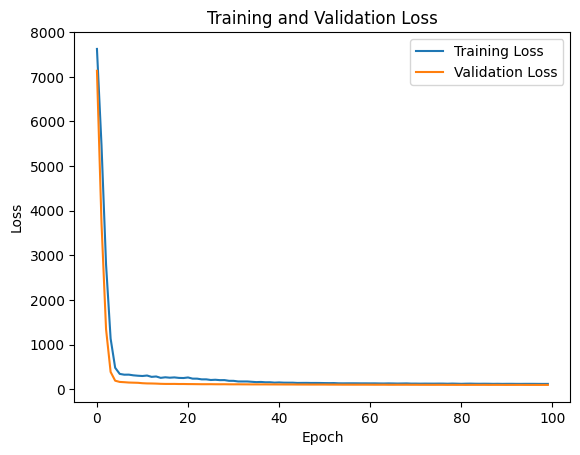

In [41]:
target_column = 'popularity'
features = data_c.drop(columns=[target_column], errors='ignore')  # 特征
target = data_c[target_column]  # 目标变量

# 替换无效值
features = features.replace([np.inf, -np.inf], np.nan).fillna(0)
target = target.fillna(target.median())

# 数据划分
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# 数据标准化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 构建神经网络模型
model = Sequential([
    Dense(512, input_dim=X_train.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)  # 输出层（回归问题）
])

# 编译模型
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

# 加入早停机制
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

# 训练模型
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

# 测试集评估
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MSE): {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# 学习曲线可视化
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
target_column = 'popularity'
features = data_c.drop(columns=[target_column], errors='ignore')  # 特征
target = data_c[target_column]  # 目标变量

# 替换无效值
features = features.replace([np.inf, -np.inf], np.nan).fillna(0)
target = target.fillna(target.median())

# 数据划分
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# 构建随机森林模型
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# 训练模型
rf_model.fit(X_train, y_train)

# 测试集预测
y_pred = rf_model.predict(X_test)

# 评估性能
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Random Forest Results:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R^2 Score: {r2:.4f}")

Random Forest Results:
Mean Squared Error (MSE): 33.2792
Mean Absolute Error (MAE): 1.3366
R^2 Score: 0.7429


#### I did not tune my cnn so random forest is much more better.

In [10]:
explainer = shap.TreeExplainer(rf_model)

import joblib

def compute_shap_values(features_batch):
    return explainer.shap_values(features_batch)

# 分块计算 SHAP 值
n_jobs = -1  # 使用所有可用 CPU
batch_size = 500  # 每次处理的样本数
features_batches = np.array_split(features, len(features) // batch_size)

shap_values = joblib.Parallel(n_jobs=n_jobs)(
    joblib.delayed(compute_shap_values)(batch) for batch in features_batches
)

# 合并 SHAP 值
shap_values = np.vstack(shap_values)

c:\Users\Aura\anaconda3\envs\deepl39\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [17]:
print(shap_values.shape)
print(features.shape)
expected_value = explainer.expected_value
print(expected_value.shape)

(20007, 11)
(20007, 11)
(1,)


In [18]:
normalized_data = pd.DataFrame(features, columns=features.columns)
shap_df = pd.DataFrame(shap_values, columns=features.columns)

# 保存特征名、归一化数据、SHAP 值到 JSON
output = {
    "features": list(features.columns),
    "normalized_data": normalized_data.to_dict(orient="records"),
    "shap_values": shap_df.to_dict(orient="records"),
    "expected_value": float(expected_value)  # 模型期望值
}

# 保存到 JSON 文件
output_file = "shap_and_normalized_data_full.json"
with open(output_file, "w") as f:
    json.dump(output, f, indent=4)

print(f"Data saved to {output_file}")

C:\Users\Aura\AppData\Local\Temp\ipykernel_29600\1342847466.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "expected_value": float(expected_value)  # 模型期望值


Data saved to shap_and_normalized_data_full.json
